## Import necessary packages

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import \
    RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import \
    StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import os
import pickle


## Functions

In [3]:

def cramers_corrected_stat(confusion_matrix):

    """ calculate Cramers V statistic for categorial-categorial association.

        uses correction from Bergsma and Wicher,

        Journal of the Korean Statistical Society 42 (2013): 323-328

    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def plot_con(con, df, c):
    for i in  con:
        plt.figure()
        sns.displot(x=i, data=df, color='c', kde=True)
        plt.show()

## 1. Data Loading

In [4]:
df = pd.read_csv('cardio_train.csv', sep=';')

In [5]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,1,20228,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,2,18857,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,3,17623,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,4,17474,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70003.0,49970.283431,28852.529858,0.0,25002.5,50000.0,74887.5,99999.0
age,70003.0,19468.876134,2467.212795,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70003.0,1.349585,0.476842,1.0,1.0,1.0,2.0,2.0
height,70001.0,164.359023,8.210026,55.0,159.0,165.0,170.0,250.0
weight,70002.0,74.206013,14.396345,10.0,65.0,72.0,82.0,200.0
ap_hi,70003.0,128.817479,154.008162,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70003.0,96.629987,188.468505,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70001.0,1.366909,0.680255,1.0,1.0,1.0,2.0,3.0
gluc,70003.0,1.226476,0.572299,1.0,1.0,1.0,1.0,3.0
smoke,70003.0,0.088125,0.283478,0.0,0.0,0.0,0.0,1.0


## 2. EDA & Data Cleaning
Raw observation
1. Age is in days
2. cholestrol and alco can be changed to int since its categorical data
3. height should be in int
4. ap_hi and ap_lo shouldnt have anomalies

In [7]:
#Converting age to year 
df['age'] = df['age'] // 365
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,2,51,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,4,47,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70003 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70003 non-null  int64  
 1   age          70003 non-null  int64  
 2   gender       70003 non-null  int64  
 3   height       70001 non-null  float64
 4   weight       70002 non-null  float64
 5   ap_hi        70003 non-null  int64  
 6   ap_lo        70003 non-null  int64  
 7   cholesterol  70001 non-null  float64
 8   gluc         70003 non-null  int64  
 9   smoke        70003 non-null  int64  
 10  alco         70002 non-null  float64
 11  active       70003 non-null  int64  
 12  cardio       70003 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 6.9 MB


### Checking for null

In [9]:
df.isna().sum()

id             0
age            0
gender         0
height         2
weight         1
ap_hi          0
ap_lo          0
cholesterol    2
gluc           0
smoke          0
alco           1
active         0
cardio         0
dtype: int64

In [10]:
df = df.dropna()
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [11]:
df.nunique()

id             69994
age               28
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

### Checking for duplicates

In [12]:
df.duplicated().sum()

3

In [13]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69994 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           69994 non-null  int64  
 1   age          69994 non-null  int64  
 2   gender       69994 non-null  int64  
 3   height       69994 non-null  float64
 4   weight       69994 non-null  float64
 5   ap_hi        69994 non-null  int64  
 6   ap_lo        69994 non-null  int64  
 7   cholesterol  69994 non-null  float64
 8   gluc         69994 non-null  int64  
 9   smoke        69994 non-null  int64  
 10  alco         69994 non-null  float64
 11  active       69994 non-null  int64  
 12  cardio       69994 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 7.5 MB


### Dropping unnecessary column

In [15]:
df=df.drop('id', axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,51,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,47,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0


### Handling outliers and anomalies

In [16]:
#Change type to int
df=df.astype({'weight':'int','height':'int','alco':'int', 'cholesterol':'int'})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,51,1,165,64,130,70,3,1,0,0,0,1
3,48,2,169,82,150,100,1,1,0,0,1,1
4,47,1,156,56,100,60,1,1,0,0,0,0


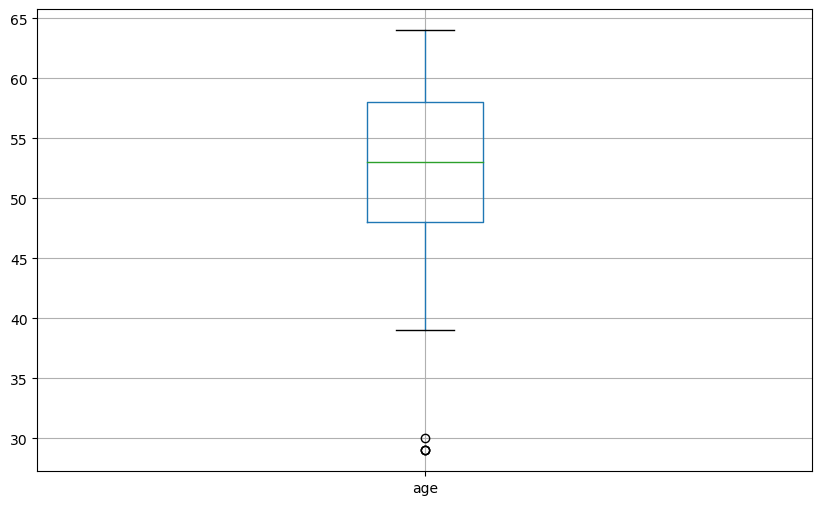

In [17]:
df.boxplot(figsize=(10,6),column=['age'])
plt.show()

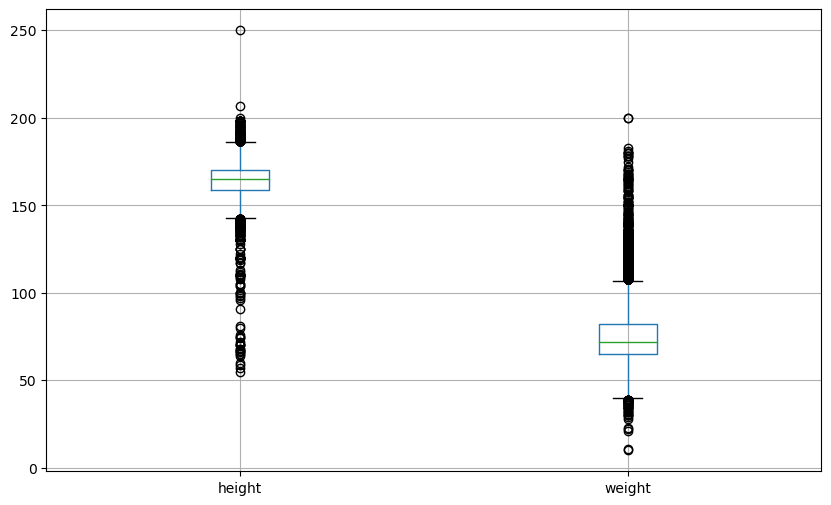

In [18]:
df.boxplot(figsize=(10,6),column=['height','weight'])
plt.show()

Theres a wide spread in height and weight, hence to handle that. I'm using the interquartile range method

In [19]:
Q1 = df['weight'].quantile(0.25)

Q3 = df['weight'].quantile(0.75)

IQR = Q3 - Q1

# filter out outliers for weight

df = df[~((df['weight'] < (Q1 - 1.5 * IQR)) | (df['weight'] > (Q3 + 1.5 * IQR)))]

Q1_h = df['height'].quantile(0.25)

Q3_h = df['height'].quantile(0.75)

IQR = Q3 - Q1

# filter out outliers for height

df = df[~((df['height'] < (Q1_h - 1.5 * IQR)) | (df['height'] > (Q3_h + 1.5 * IQR)))]



This shows the boxplot once it is handled

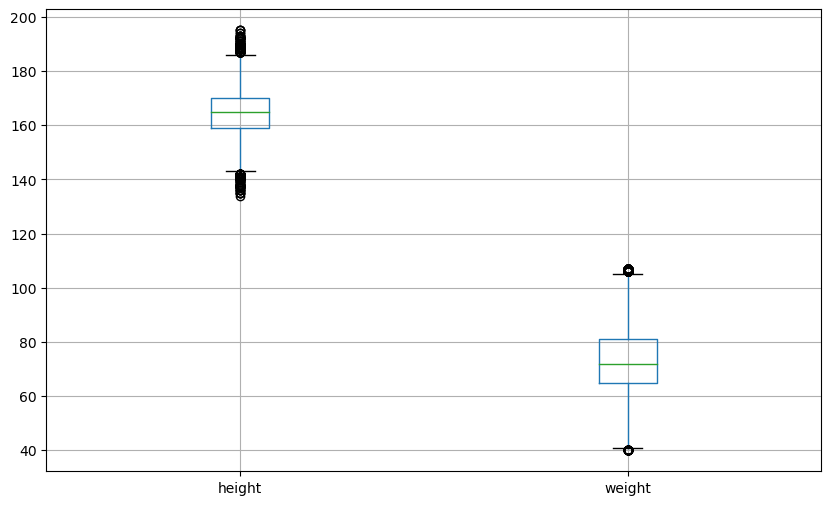

(68049, 12)

In [20]:
df.boxplot(figsize=(10,6),column=['height','weight'])
plt.show()
df.shape

**ap_hi**
range should be between 0 and 250

**ap_lo**
range should be between 0 and 200

Hence, there are anomalies detected

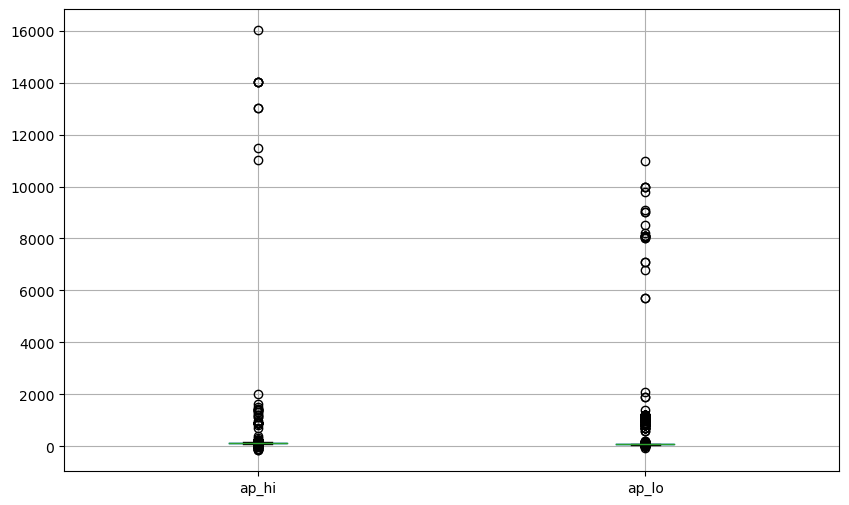

In [21]:
df.boxplot(figsize=(10,6),column=['ap_hi','ap_lo'])
plt.show()

In [22]:
df['ap_hi'] = df['ap_hi'].clip(0,250)
df['ap_lo'] = df['ap_lo'].clip(0,200)

Below, shows the boxplot and description once it is handled via .clip method

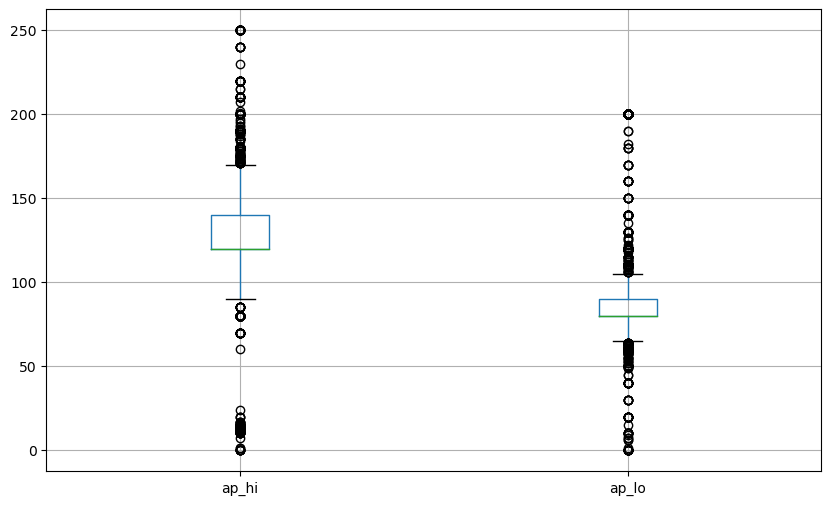

,count,mean,std,min,25%,50%,75%,max
age,68049.0,52.838837,6.768915,29.0,48.0,53.0,58.0,64.0
gender,68049.0,1.347235,0.476095,1.0,1.0,1.0,2.0,2.0
height,68049.0,164.336581,7.738666,134.0,159.0,165.0,170.0,195.0
weight,68049.0,73.078679,12.437565,40.0,65.0,72.0,81.0,107.0
ap_hi,68049.0,126.461256,18.126894,0.0,120.0,120.0,140.0,250.0
ap_lo,68049.0,82.730856,16.625828,0.0,80.0,80.0,90.0,200.0
cholesterol,68049.0,1.359741,0.674730,1.0,1.0,1.0,1.0,3.0
gluc,68049.0,1.220856,0.566625,1.0,1.0,1.0,1.0,3.0
smoke,68049.0,0.086996,0.281831,0.0,0.0,0.0,0.0,1.0
alco,68049.0,0.052844,0.223724,0.0,0.0,0.0,0.0,1.0


In [23]:
df.boxplot(figsize=(10,6),column=['ap_hi','ap_lo'])
plt.show()
df.describe().T

### Feature Engineering

In [24]:
df["bmi"] = df["weight"] / (df["height"]/100)**2
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56,100,60,1,1,0,0,0,0,23.011177


In [25]:
df.shape

(68049, 13)

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,68049.0,52.838837,6.768915,29.000000,48.000000,53.000000,58.000000,64.000000
gender,68049.0,1.347235,0.476095,1.000000,1.000000,1.000000,2.000000,2.000000
height,68049.0,164.336581,7.738666,134.000000,159.000000,165.000000,170.000000,195.000000
weight,68049.0,73.078679,12.437565,40.000000,65.000000,72.000000,81.000000,107.000000
ap_hi,68049.0,126.461256,18.126894,0.000000,120.000000,120.000000,140.000000,250.000000
ap_lo,68049.0,82.730856,16.625828,0.000000,80.000000,80.000000,90.000000,200.000000
cholesterol,68049.0,1.359741,0.674730,1.000000,1.000000,1.000000,1.000000,3.000000
gluc,68049.0,1.220856,0.566625,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,68049.0,0.086996,0.281831,0.000000,0.000000,0.000000,0.000000,1.000000
alco,68049.0,0.052844,0.223724,0.000000,0.000000,0.000000,0.000000,1.000000


In [27]:
con = ['age','height','weight','ap_hi','ap_lo','bmi']
cat = df.drop(labels=con, axis=1).columns

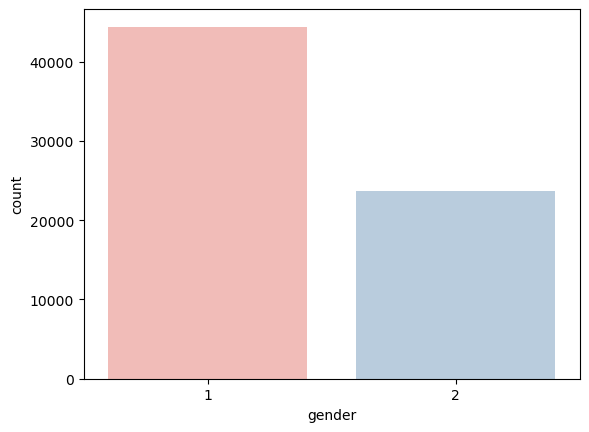

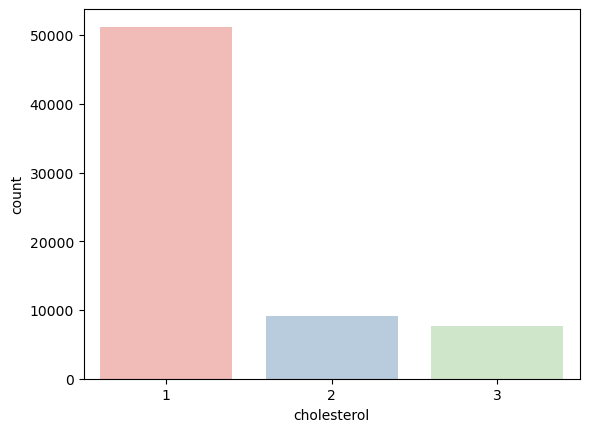

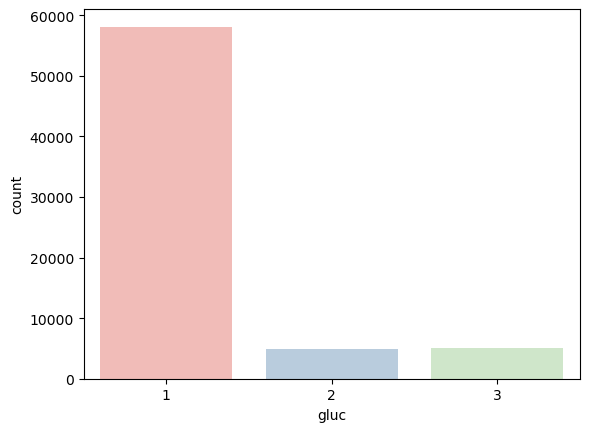

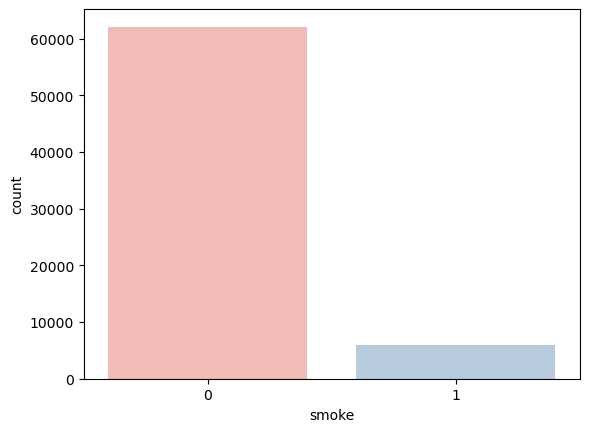

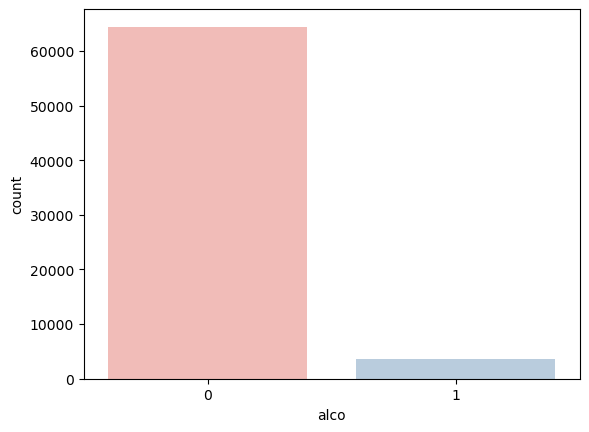

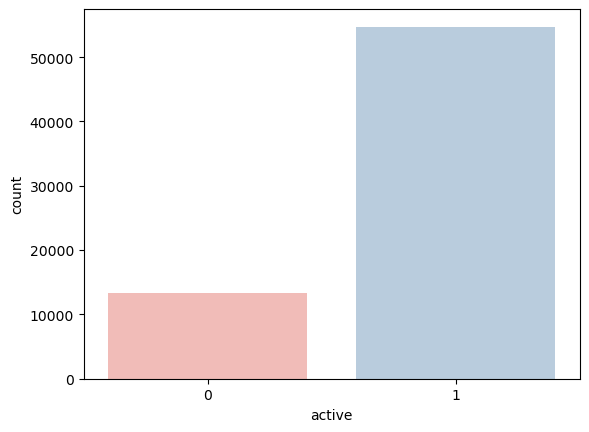

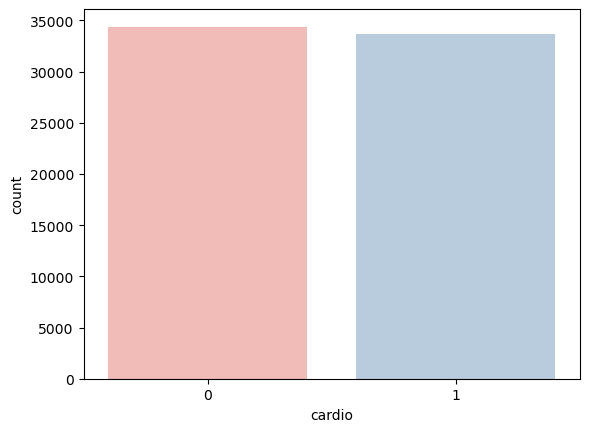

In [28]:
for x in cat:
    sns.countplot(x=x, data=df, palette='Pastel1')
    plt.show()

<Figure size 640x480 with 0 Axes>

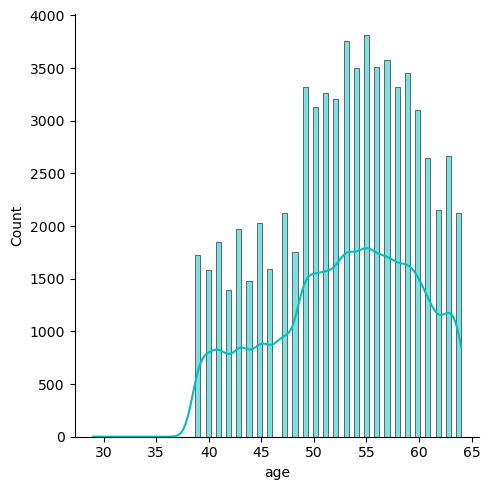

<Figure size 640x480 with 0 Axes>

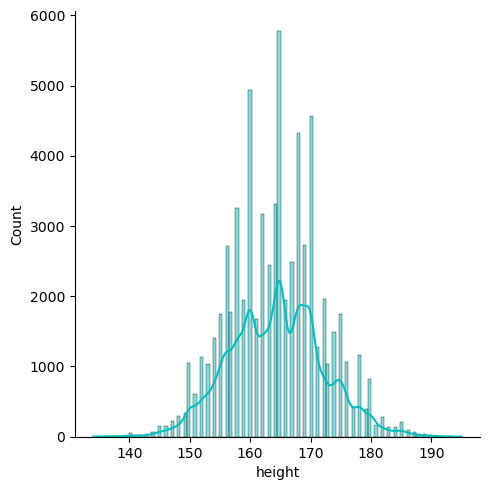

<Figure size 640x480 with 0 Axes>

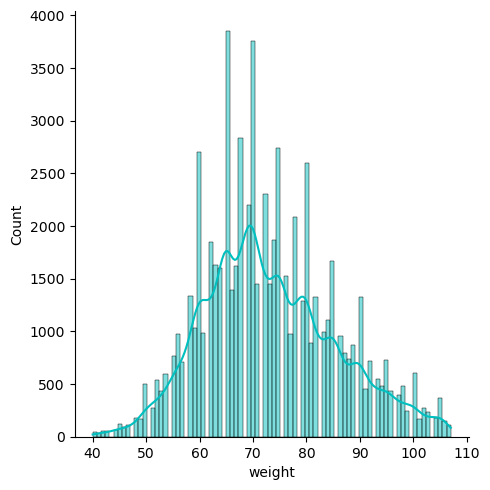

<Figure size 640x480 with 0 Axes>

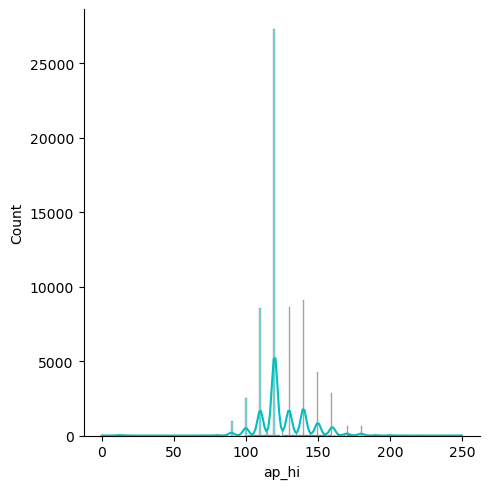

<Figure size 640x480 with 0 Axes>

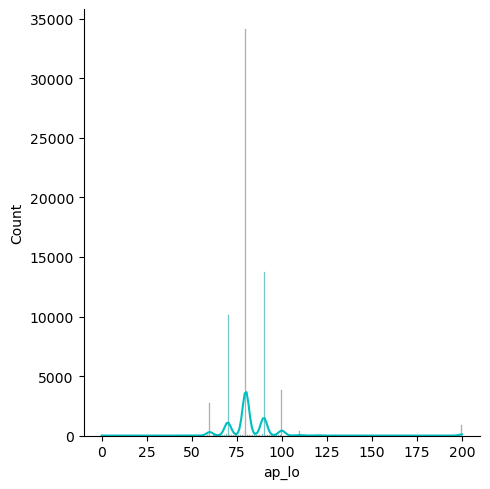

<Figure size 640x480 with 0 Axes>

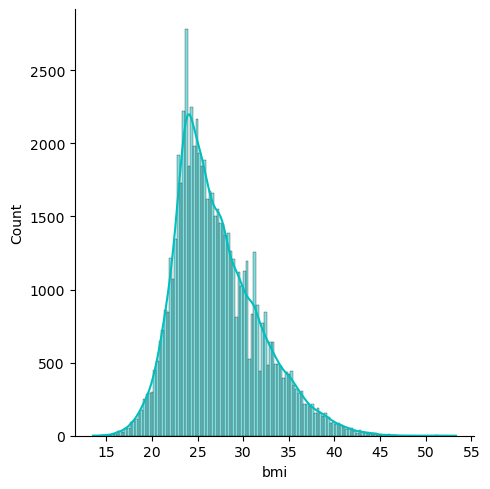

In [29]:
plot_con(con,df,'blue')

In [30]:
for i in cat:
    print(i)
    matrix = pd.crosstab(df[i], df['cardio']).to_numpy()
    print(cramers_corrected_stat(matrix))


#Finding correlation for con-to-con data
for i in con:
    print(i)
    lr = LogisticRegression()
    lr.fit(np.expand_dims(df[i], axis=1),df['cardio'])
    print(lr.score(np.expand_dims(df[i], axis=1),df['cardio']))

gender
0.0035758536136111666
cholesterol
0.22038053263776078
gluc
0.09070427577515001
smoke
0.018132149126758382
alco
0.008241590984399494
active
0.03524784012745756
cardio
0.9999706055898813
age
0.5980249526076797
height
0.5109406457111787
weight
0.5735719848932387
ap_hi
0.71389733868242
ap_lo
0.6622139928580876
bmi
0.5803465150112419


In [31]:
#Finding the correlation coefficient between con data to output
df_con = df.loc[:,['age','height','weight','ap_hi','ap_lo','bmi','cardio']]
corr = df_con.corr()
display(corr)

,age,height,weight,ap_hi,ap_lo,bmi,cardio
age,1.000000,-0.086368,0.066538,0.195978,0.106160,0.117731,0.241707
height,-0.086368,1.000000,0.315705,0.002953,0.012483,-0.243986,-0.020267
weight,0.066538,0.315705,1.000000,0.235617,0.173486,0.838926,0.176611
ap_hi,0.195978,0.002953,0.235617,1.000000,0.500293,0.238809,0.400229
ap_lo,0.106160,0.012483,0.173486,0.500293,1.000000,0.169744,0.254987
bmi,0.117731,-0.243986,0.838926,0.238809,0.169744,1.000000,0.191081
cardio,0.241707,-0.020267,0.176611,0.400229,0.254987,0.191081,1.000000


In [32]:
df_con.corr()['cardio'].sort_values

<bound method Series.sort_values of age       0.241707
height   -0.020267
weight    0.176611
ap_hi     0.400229
ap_lo     0.254987
bmi       0.191081
cardio    1.000000
Name: cardio, dtype: float64>

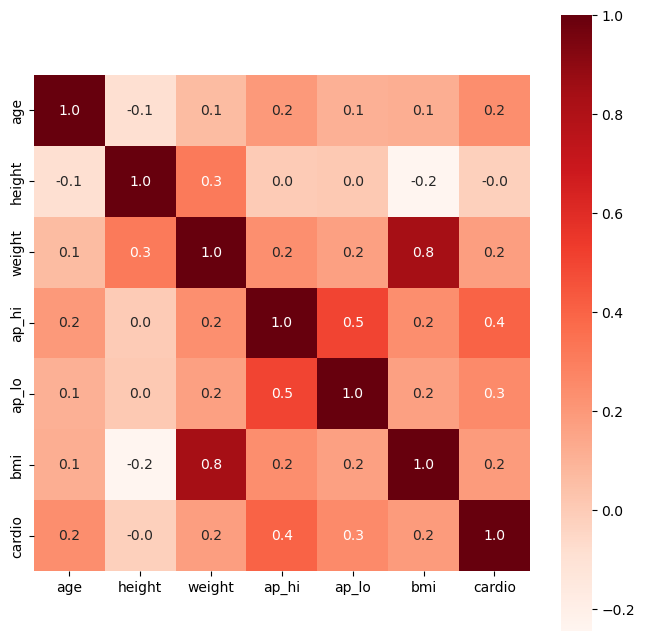

In [33]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, cmap='Reds', annot=True, square=True, fmt='.1f')
plt.show()

## 3. Data Preprocessing

In [34]:
X = df.drop(['cardio'],axis=1)
y = df['cardio']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

## 4. Model Development

### Pipelines

Fitting in scalers and classification methods into pipelines.

**Scalers**
1. MinMaxScaler
2. StandardScaler

**Classification Method**
1. Logistic Regression
2. Gradient Booster Classifier
3. SVC
4. Random Forest Classifier
5. Decision Tree Classifier
6. K-Nearest Neighbor


In [36]:
#logistic regression
pipeline_mms_lr = Pipeline([
                            ('min_max_scaler', MinMaxScaler()),
                            ('logistic_regression', LogisticRegression())
                            ])

pipeline_ss_lr = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('logistic_regression', LogisticRegression())
                            ])

#gradient booster
pipeline_mms_gbs = Pipeline([
                            ('min_max_scaler', MinMaxScaler()),
                            ('gradient_boosting_classifier', GradientBoostingClassifier())
                            ])

pipeline_ss_gbs = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('gradient_boosting_classifier', GradientBoostingClassifier())
                            ])
#SVC
pipeline_mms_svc = Pipeline([
                            ('min_max_scaler', MinMaxScaler()),
                            ('svc', SVC())
                            ])

pipeline_ss_svc = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('svc', SVC())
                            ])     

#random forest classifier
pipeline_mms_rfc = Pipeline([
                            ('min_max_scaler', MinMaxScaler()),
                            ('random_forest_classifier', RandomForestClassifier())
                            ])

pipeline_ss_rfc = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('random_forest_classifier', RandomForestClassifier())
                            ])  

#decision tree classifier
pipeline_mms_dt = Pipeline([
                            ('min_max_scaler', MinMaxScaler()),
                            ('decision_tree_classifier', DecisionTreeClassifier())
                            ])

pipeline_ss_dt = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('decision_tree_classifier', DecisionTreeClassifier())
                            ]) 

#knn 
pipeline_mms_knn = Pipeline([
                            ('standard_scaler', MinMaxScaler()),
                            ('k_nearest_neighbor_classifier', KNeighborsClassifier())
                            ]) 

pipeline_ss_knn = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('k_nearest_neighbor_classifier', KNeighborsClassifier())
                            ]) 

#Storing pipelines in a list
pipelines = [pipeline_mms_lr, pipeline_ss_lr, 
            pipeline_mms_gbs, pipeline_ss_gbs, 
            pipeline_mms_svc, pipeline_ss_svc, 
            pipeline_mms_rfc, pipeline_ss_rfc,
            pipeline_mms_dt, pipeline_ss_dt,
            pipeline_mms_knn, pipeline_ss_knn]

### Finding the best pipeline with the highest accuracy score

In [37]:
#fitting training data - model training
for pipe in pipelines:
    pipe.fit(X_train, y_train)

pipe_dict = {}
best_score = 0 

model_name = ['MMS + Logistic Regression', 'SS + Logistic Regression',
                'MMS + Random Forest', 'SS + Random Forest',
                'MMS + SVC', 'SS + SVC',
                'MMS + Gradient Boosting Classifier', 'SS + Gradient Boosting Classifier',
                'MMS + Decision Tree Classifier', 'SS + Decision Tree Classifier',
                'MMS + K Nearest Neighbor Classifier', 'SS + K Nearest Neighbor Classifier']

#Model evaluation
for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test) 

    pipe_dict[model_name[i]] = [accuracy_score(y_test, y_pred),
                                f1_score(y_test, y_pred, average='weighted')]
    
    if model.score(X_test, y_test) > best_score:
        best_score = model.score(X_test, y_test)
        best_pipe = model_name[i]

print('The best model for cardiovascular disease prediction is {} with the accuracy of {}'.format(best_pipe, best_score))

The best model for cardiovascular disease prediction is MMS + Random Forest with the accuracy of 0.737790840068577


**Best Model: MMS + Random Forest Classifier**

**Accuracy: 7.738**

## 5. Model Comparison Table

In [38]:
#Convert pipe_dict into a model comparison dataframe
model_comparison_df = pd.DataFrame.from_dict(pipe_dict).T
model_comparison_df.columns=['Accuracy','F1 Score']
model_comparison_df = model_comparison_df.sort_values(by=['Accuracy'], ascending=False)
model_comparison_df.style.background_gradient(cmap='BuPu')

,Accuracy,F1 Score
MMS + Random Forest,0.737791,0.737276
SS + Random Forest,0.737791,0.737276
SS + SVC,0.736272,0.735223
MMS + SVC,0.733333,0.732341
MMS + Logistic Regression,0.729611,0.728737
SS + Logistic Regression,0.729219,0.728300
SS + Gradient Boosting Classifier,0.713495,0.713429
MMS + Gradient Boosting Classifier,0.711585,0.711502
SS + K Nearest Neighbor Classifier,0.694979,0.694893
MMS + K Nearest Neighbor Classifier,0.684056,0.683944


## 6. Hyperparameter Tuning

### Grid Search

In [39]:
pipeline_mms_rfc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'min_max_scaler', 'random_forest_classifier', 'min_max_scaler__clip', 'min_max_scaler__copy', 'min_max_scaler__feature_range', 'random_forest_classifier__bootstrap', 'random_forest_classifier__ccp_alpha', 'random_forest_classifier__class_weight', 'random_forest_classifier__criterion', 'random_forest_classifier__max_depth', 'random_forest_classifier__max_features', 'random_forest_classifier__max_leaf_nodes', 'random_forest_classifier__max_samples', 'random_forest_classifier__min_impurity_decrease', 'random_forest_classifier__min_samples_leaf', 'random_forest_classifier__min_samples_split', 'random_forest_classifier__min_weight_fraction_leaf', 'random_forest_classifier__n_estimators', 'random_forest_classifier__n_jobs', 'random_forest_classifier__oob_score', 'random_forest_classifier__random_state', 'random_forest_classifier__verbose', 'random_forest_classifier__warm_start'])

In [47]:
grid_param = {'random_forest_classifier__n_estimators': [100,300],
               'random_forest_classifier__max_features': ['auto','sqrt'],
               'random_forest_classifier__max_depth': [2,4],
               'random_forest_classifier__min_samples_split': [2,5],
               'random_forest_classifier__min_samples_leaf': [1,2],
               'random_forest_classifier__bootstrap': [True,False]}

grid_search = GridSearchCV(pipeline_mms_rfc, grid_param,
                            cv=5, verbose=1, n_jobs=-1)

grid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [48]:
print(grid_search.score(X_test, y_test))

0.7306882194464854


In [49]:
display(grid.best_params_)

{'random_forest_classifier__bootstrap': True,
 'random_forest_classifier__max_depth': 4,
 'random_forest_classifier__max_features': 'sqrt',
 'random_forest_classifier__min_samples_leaf': 2,
 'random_forest_classifier__min_samples_split': 2,
 'random_forest_classifier__n_estimators': 300}

### Random Search

In [44]:
rand_param = {'random_forest_classifier__n_estimators': [100,300],
               'random_forest_classifier__max_features': ['auto','sqrt'],
               'random_forest_classifier__max_depth': [2,4],
               'random_forest_classifier__min_samples_split': [2,5],
               'random_forest_classifier__min_samples_leaf': [1,2],
               'random_forest_classifier__bootstrap': [True,False]}

rand_search = RandomizedSearchCV(pipeline_mms_rfc, rand_param,
                                    cv=5, verbose=1, n_jobs=-1)

rand = rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\tasha\anaconda3\envs\ml_env\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [45]:
print(rand_search.score(X_test, y_test))

0.7311290717609601


In [46]:
display(rand.best_params_)

{'random_forest_classifier__n_estimators': 100,
 'random_forest_classifier__min_samples_split': 5,
 'random_forest_classifier__min_samples_leaf': 2,
 'random_forest_classifier__max_features': 'auto',
 'random_forest_classifier__max_depth': 4,
 'random_forest_classifier__bootstrap': False}

Summary: From the grid search and random search, the hyperparameters acquired by the random search has a slightly higher accuracy score

## 7. Model Evaluation

In [50]:
y_pred = rand.predict(X_test)

labels = ['No Cardiovascular Disease', 'Has Cardiovascular Disease']
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=labels)

In [51]:
print(cr)

                            precision    recall  f1-score   support

 No Cardiovascular Disease       0.70      0.81      0.75     10317
Has Cardiovascular Disease       0.77      0.65      0.71     10098

                  accuracy                           0.73     20415
                 macro avg       0.74      0.73      0.73     20415
              weighted avg       0.74      0.73      0.73     20415



From the classification report, we can see that the **validation accuracy** is **73%**

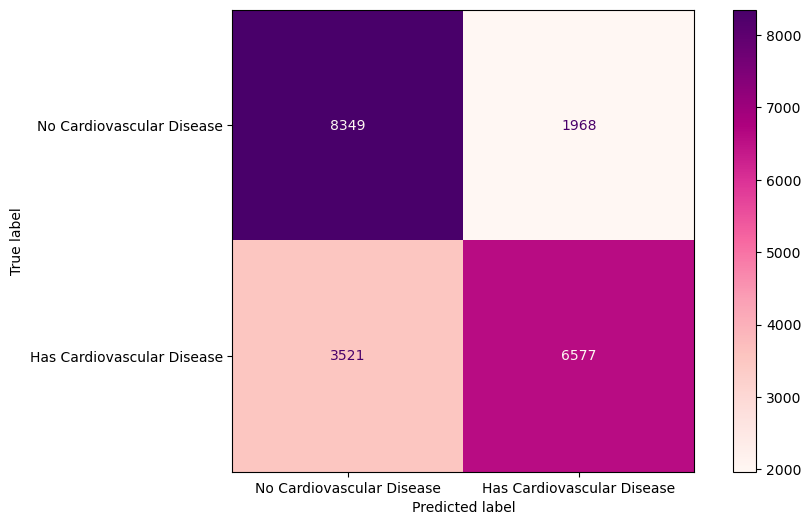

In [98]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='RdPu')
plt.rcParams['figure.figsize'] = [10,6]
plt.show()


## 8. Save Model

In [102]:
MODEL_PATH = os.path.join(os.getcwd(),'cardio_model','cardio_model.pkl')
with open(MODEL_PATH,'wb') as file:
    pickle.dump(rand.best_estimator_,file)

## 9. Test Case

### 9.1 Load test data

In [69]:
df2 = pd.read_csv('test_set.csv', sep=';')
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,1,14791,2,165,60.0,120,80,1,1,0,0,0,0
1,2,11817,1,159,77.0,111,68,1,1,0,0,1,0
2,3,14531,2,181,95.0,129,90,1,1,1,1,1,0
3,4,16782,2,172,112.0,120,80,1,1,0,0,0,1
4,5,21197,2,167,92.0,140,80,1,1,0,0,1,1


### 9.2 Data cleaning & EDA

In [71]:
df2['age'] = df2['age'] // 365
df2 = df2.drop('id', axis=1)
df2 = df2.astype({'weight':'int'})
df2.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,40,2,165,60,120,80,1,1,0,0,0,0
1,32,1,159,77,111,68,1,1,0,0,1,0
2,39,2,181,95,129,90,1,1,1,1,1,0
3,45,2,172,112,120,80,1,1,0,0,0,1
4,58,2,167,92,140,80,1,1,0,0,1,1


In [72]:
df2['bmi'] =  df2['weight'] / (df['height']/100)**2
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56,100,60,1,1,0,0,0,0,23.011177


In [97]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5.0,42.800000,9.679876,32.000000,39.000000,40.000000,45.000000,58.000000
gender,5.0,1.800000,0.447214,1.000000,2.000000,2.000000,2.000000,2.000000
height,5.0,168.800000,8.258329,159.000000,165.000000,167.000000,172.000000,181.000000
weight,5.0,87.200000,19.639246,60.000000,77.000000,92.000000,95.000000,112.000000
ap_hi,5.0,124.000000,10.977249,111.000000,120.000000,120.000000,129.000000,140.000000
ap_lo,5.0,79.600000,7.797435,68.000000,80.000000,80.000000,80.000000,90.000000
cholesterol,5.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
gluc,5.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
smoke,5.0,0.200000,0.447214,0.000000,0.000000,0.000000,0.000000,1.000000
alco,5.0,0.200000,0.447214,0.000000,0.000000,0.000000,0.000000,1.000000


In [73]:
df2.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
bmi            0
dtype: int64

In [74]:
df2.duplicated().sum()

0

In [83]:
df2.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
bmi            0
dtype: int64

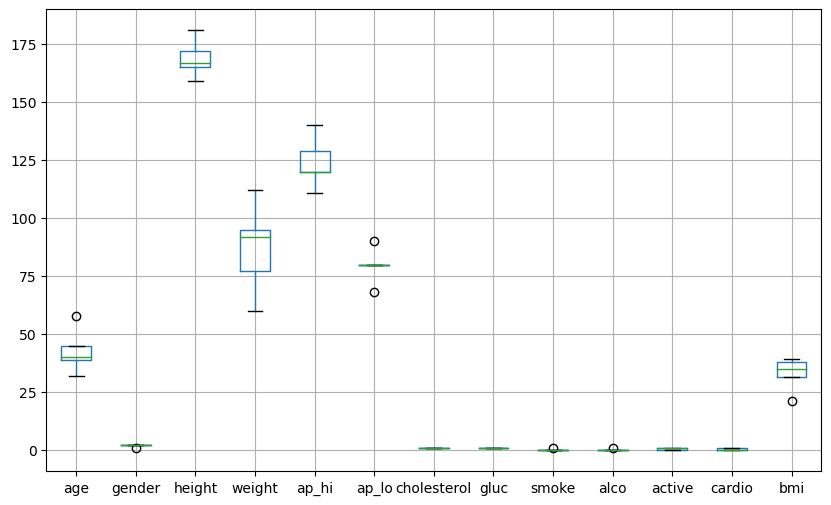

In [99]:
df2.boxplot(figsize=(10,6))
plt.show()

### 9.3 Test Data Preprocessing

In [76]:
test_data_X = df2.drop(['cardio'],axis=1)
test_data_y = df2['cardio']

In [77]:
y_pred_test = rand.predict(test_data_X)


### 9.4 Model Evaluation on Test Data

In [96]:
score = accuracy_score(y_true=test_data_y, y_pred=y_pred_test)
print(score)

0.8


In [85]:
y_pred = rand.predict(test_data_X)

labels = ['No Cardiovascular Disease', 'Has Cardiovascular Disease']
cm2 = confusion_matrix(test_data_y, y_pred)
cr2 = classification_report(test_data_y, y_pred, target_names=labels)

In [87]:
print(cr2)

                            precision    recall  f1-score   support

 No Cardiovascular Disease       0.75      1.00      0.86         3
Has Cardiovascular Disease       1.00      0.50      0.67         2

                  accuracy                           0.80         5
                 macro avg       0.88      0.75      0.76         5
              weighted avg       0.85      0.80      0.78         5



From the Classification Report, we can see that the **validation accuracy** is **80%**

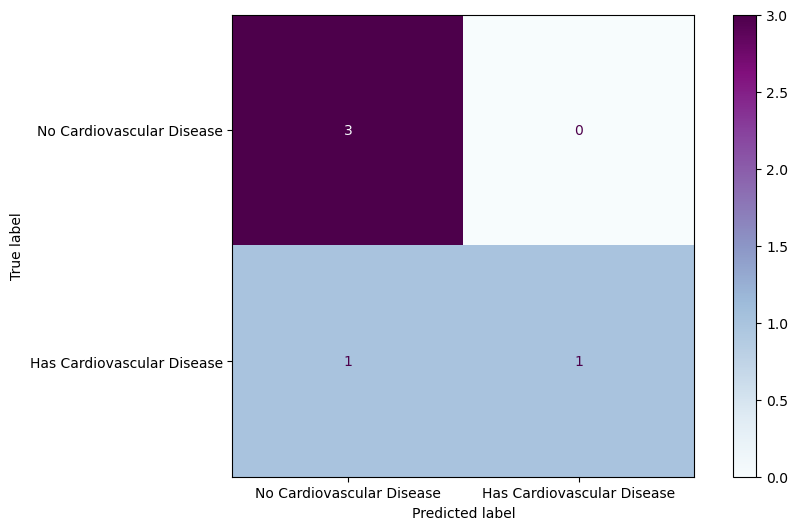

In [94]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp.plot(cmap='BuPu')
plt.rcParams['figure.figsize'] = [10,6]
plt.show()

From the confusion matrix, 3 out of 3 **No Cardiovascular Disease** are predicted accurately. However, 1 out of 2 **Has Cardiovascular Disease** is predicted accurately.